<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Осень 2020</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/t/f50bc21dbe0e42dabe5e32a21f2e5235) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика. 

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


# Первая часть. Исследование.

In [1]:
%%capture
%%bash
pip install catboost
pip install category_encoders
pip install sklearn-pandas
pip install imblearn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
%%bash

pip install kaggle
cp -r /content/drive/MyDrive/colab_settings/.kaggle /root/
kaggle competitions download -c advanced-dls-spring-2021

In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, LogisticRegressionCV
from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline, Pipeline, make_union
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.utils import shuffle, class_weight
from sklearn.feature_selection import *
from catboost import CatBoostClassifier, Pool, cv as catboost_cv
import catboost as cb
from sortedcontainers import SortedList
import copy
import collections
from itertools import product,chain
from category_encoders import CatBoostEncoder
import random
random_state = 42
random.seed(42)
np.random.seed(42)
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
###helpers functions

def display_classification_report(y_true, y_pred):
    display(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T)

def plot_roc(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        if not ax: fig, ax = plt.subplots(1, 1)
        fpr, tpr, thresholds = roc_curve(y_test, preds)
        ax.plot([0, 1], [0, 1],'r--')
        ax.plot(fpr, tpr, lw=2, label=label)
        ax.legend(loc='lower right')
        ax.set_title(
             'ROC curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(fpr, tpr):.2}')
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.annotate(f'AUC: {auc(fpr, tpr):.2}', xy=(.43, .025))
        ax.legend()
        ax.grid()
        return ax
    

def plot_pr(y_test, preds, ax=None, label='model'):
    with plt.style.context('seaborn-whitegrid'):
        precision, recall, thresholds = precision_recall_curve(y_test, preds)
        if not ax: fig, ax = plt.subplots()
        ax.plot([0, 1], [1, 0],'r--')    
        ax.plot(recall, precision, lw=2, label=label)
        ax.legend()
        ax.set_title(
            'Precision-recall curve\n'
            f""" AP: {average_precision_score(
                y_test, preds, pos_label=1
            ):.2} | """
            f'AUC: {auc(recall, precision):.2}'
        )
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_xlim(-0.05, 1.05)
        ax.set_ylim(-0.05, 1.05)
        ax.legend()
        ax.grid()
        return ax


#missing value ratio
def missing_values(df):
    df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
    df_nulls.columns = ["type","count","missing_ratio"]
    df_nulls=df_nulls[df_nulls["count"]>0]
    df_nulls.sort_values(by="missing_ratio", ascending=False)
    return df_nulls

#outliers by 3 sigma rule
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

# full description statistics 
def describe_full(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing count'] = df_numeric.isnull().sum()
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

def display_group_density_plot(df, groupby, on, palette = None, figsize = None, title="", ax=None): 
    """
    Displays a density plot by group, given a continuous variable, and a group to split the data by
    :param df: DataFrame to display data from
    :param groupby: Column name by which plots would be grouped (Categorical, maximum 10 categories)
    :param on: Column name of the different density plots
    :param palette: Color palette to use for drawing
    :param figsize: Figure size
    :return: matplotlib.axes._subplots.AxesSubplot object
    """
    if palette is None:
      palette = sns.color_palette('Set2')
    if figsize is None:
      figsize = (10, 5)
    if not isinstance(df, pd.core.frame.DataFrame):
        raise ValueError('df must be a pandas DataFrame')

    if not groupby:
        raise ValueError('groupby parameter must be provided')

    elif not groupby in df.keys():
        raise ValueError(groupby + ' column does not exist in the given DataFrame')

    if not on:
        raise ValueError('on parameter must be provided')

    elif not on in df.keys():
        raise ValueError(on + ' column does not exist in the given DataFrame')

    if len(set(df[groupby])) > 10:
        groups = df[groupby].value_counts().index[:10]

    else:
        groups = set(df[groupby])

    # Get relevant palette
    if palette:
        palette = palette[:len(groups)]
    else:
        palette = sns.color_palette()[:len(groups)]

    if ax is None:
      fig = plt.figure(figsize=figsize)
      ax = fig.add_subplot(111)
    
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    for value, color in zip(groups, palette):
        sns.kdeplot(df.loc[df[groupby] == value][on],                     shade=True, color=color, label=value, ax=ax)
    if not title:
      title = str("Distribution of " + on + " per " + groupby + " group")
    
    ax.set_title(title,fontsize=10)
    ax.set_xlabel(on, fontsize=10)
    return ax 

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [6]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [7]:
# data_train = pd.read_csv('train.csv')
# data_train["split"] = "train"
# data_test = pd.read_csv('test.csv')
# data_test["split"] = "test"
# data = pd.concat([data_train, data_test], axis=0)

In [7]:
data = pd.read_csv('train.csv')

In [8]:
data = shuffle(data, random_state=random_state)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 1448 to 860
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnl

In [10]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1448,9,45.40,418.8,Male,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,1
4792,37,70.35,2552.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,0
8,50,105.95,5341.8,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Month-to-month,No,Credit card (automatic),1
3964,44,100.10,4378.35,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),0
240,25,20.95,495.15,Male,0,Yes,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0


In [11]:
describe_full(data)

,count,mean,std,min,25%,50%,75%,max,dtypes,Missing count,Missing %,Cardinality,Skew,outliers,kurtosis
ClientPeriod,5282.0,32.397009,24.550326,0.00,9.0000,29.0,55.00,72.00,int64,0,0.0,73,0.241959,0,-1.380820
MonthlySpending,5282.0,64.924754,30.176464,18.25,35.4625,70.4,90.05,118.75,float64,0,0.0,1468,-0.223028,0,-1.261744
IsSeniorCitizen,5282.0,0.159409,0.366092,0.00,0.0000,0.0,0.00,1.00,int64,0,0.0,2,1.861388,0,1.465321
Churn,5282.0,0.262022,0.439776,0.00,0.0000,0.0,1.00,1.00,int64,0,0.0,2,1.082679,0,-0.828120


In [12]:
pd.DataFrame({"col":data.select_dtypes(include="object").columns,
              "unique": [len(data[col].unique()) for col in data.select_dtypes(include="object").columns],
              "values": [data[col].unique() for col in data.select_dtypes(include="object").columns]})

,col,unique,values
0,TotalSpent,4978,"[418.8, 2552.9, 5341.8, 4378.35, 495.15, 2011...."
1,Sex,2,"[Male, Female]"
2,HasPartner,2,"[No, Yes]"
3,HasChild,2,"[No, Yes]"
4,HasPhoneService,2,"[No, Yes]"
5,HasMultiplePhoneNumbers,3,"[No phone service, No, Yes]"
6,HasInternetService,3,"[DSL, Fiber optic, No]"
7,HasOnlineSecurityService,3,"[No, Yes, No internet service]"
8,HasOnlineBackup,3,"[No, No internet service, Yes]"
9,HasDeviceProtection,3,"[No, Yes, No internet service]"


как мы видим в основном мы имеем дело с категориальными величинами, пропущенных значений нет, но давайте переведем object в numeric для totalspent 

In [13]:
try:
  pd.to_numeric(data["TotalSpent"], errors="raise")
except Exception as e:
  print(e)

Unable to parse string " " at position 755


In [14]:
def convert_types_data(data):
  data["TotalSpent"] = data["TotalSpent"].str.strip()
  data.loc[data["TotalSpent"] == "", "TotalSpent"] = "0.0" 
  data["TotalSpent"] = pd.to_numeric(data["TotalSpent"], errors="raise")
  return data

In [15]:
data = convert_types_data(data)

In [16]:
data.duplicated().sum()

14

In [17]:
data[data.duplicated()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2991,1,20.90,20.90,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
1474,1,20.05,20.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1898,1,70.10,70.10,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
4509,1,69.20,69.20,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
409,1,69.60,69.60,Female,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
329,1,69.35,69.35,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
3735,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4530,1,45.30,45.30,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,1
1384,1,69.90,69.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
1217,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,1


давайте уберем дубли

In [18]:
data = data[~data.duplicated()]

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

In [19]:
pd.DataFrame({"col":cat_cols,
              "unique": [len(data[col].unique()) for col in cat_cols],
              "values": [data[col].unique() for col in cat_cols]})

,col,unique,values
0,Sex,2,"[Male, Female]"
1,IsSeniorCitizen,2,"[0, 1]"
2,HasPartner,2,"[No, Yes]"
3,HasChild,2,"[No, Yes]"
4,HasPhoneService,2,"[No, Yes]"
5,HasMultiplePhoneNumbers,3,"[No phone service, No, Yes]"
6,HasInternetService,3,"[DSL, Fiber optic, No]"
7,HasOnlineSecurityService,3,"[No, Yes, No internet service]"
8,HasOnlineBackup,3,"[No, No internet service, Yes]"
9,HasDeviceProtection,3,"[No, Yes, No internet service]"


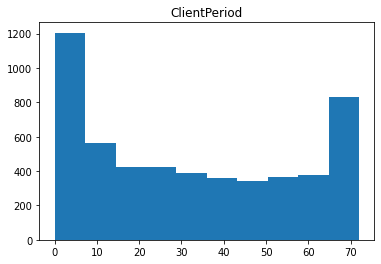

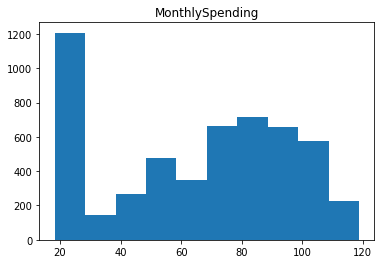

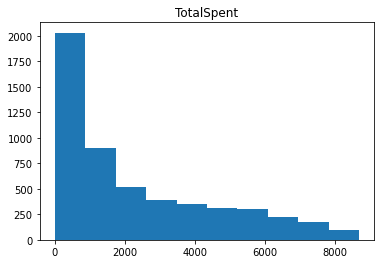

In [ ]:
for col in num_cols:
  plt.hist(data[col])
  plt.title(col)
  plt.show()

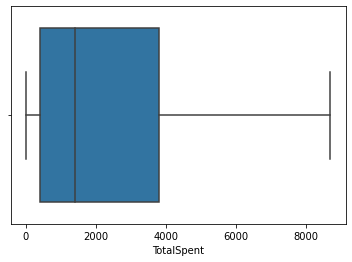

In [ ]:
sns.boxplot(data['TotalSpent'])

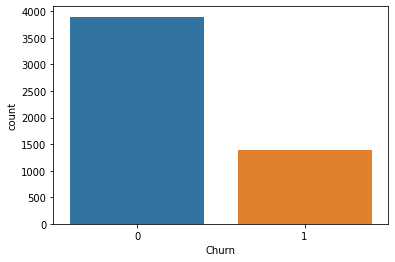

In [ ]:
sns.countplot(data["Churn"])

действительно несбалансированно, но не сказать что фатально

наиболее важные фичи по мнению катбуст

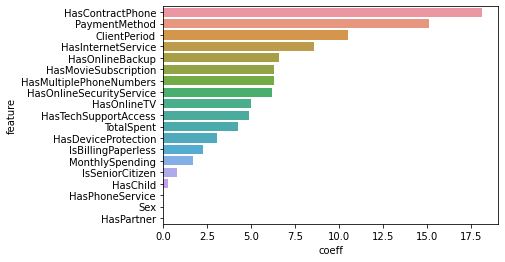

In [26]:
X, y = data[feature_cols], data[target_col]
X_train, X_test, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_state)
train_ds = Pool(data=X_train, label=y_train, cat_features=cat_cols, feature_names=feature_cols)
test_ds = Pool(data=X_test, label=y_val, cat_features=cat_cols, feature_names=feature_cols)
full_ds = Pool(data=X, label=y, cat_features=cat_cols, feature_names=feature_cols)

classes = np.unique(y_train)
weights = class_weight.compute_class_weight('balanced', classes, y_train)
class_weights = dict(zip(classes, weights))

cb = CatBoostClassifier(verbose=0, class_weights=class_weights,task_type="GPU", 
                        devices='0:1', random_seed=random_state).fit(train_ds)
df_feature_importances = pd.DataFrame(((zip(cb.feature_names_, cb.get_feature_importance())))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

In [29]:
try:
  del X, y, X_train, X_val, y_train, y_val, train_ds, test_ds, full_ds
except:
  pass

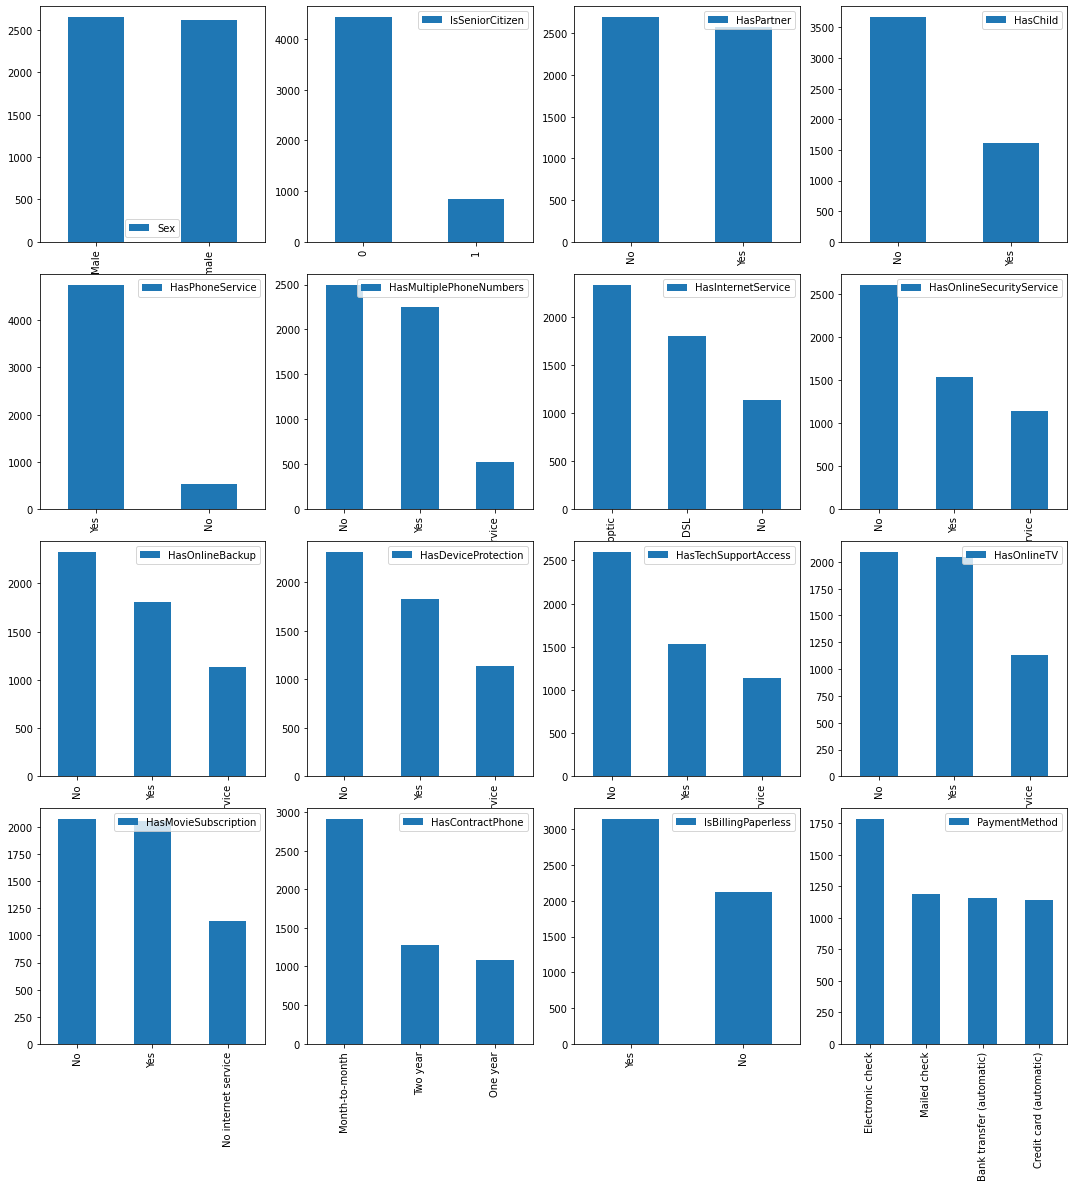

In [30]:
fig, axs = plt.subplots(4, len(cat_cols) // 4, figsize=(15,15))
axs = axs.flatten()
plt.tight_layout()
for cat_col, ax in zip(cat_cols, axs):
     data[cat_col].value_counts().plot(kind='bar', ax=ax)
     ax.legend()

plt.show()

In [31]:
display(data["Churn"].value_counts())
100*data["Churn"].value_counts()/len(data)

0    3894
1    1374
Name: Churn, dtype: int64

0    73.917995
1    26.082005
Name: Churn, dtype: float64

как видим классы несбалансированы, неплохо бы оверсэмплить(либо указывать веса катабусту)

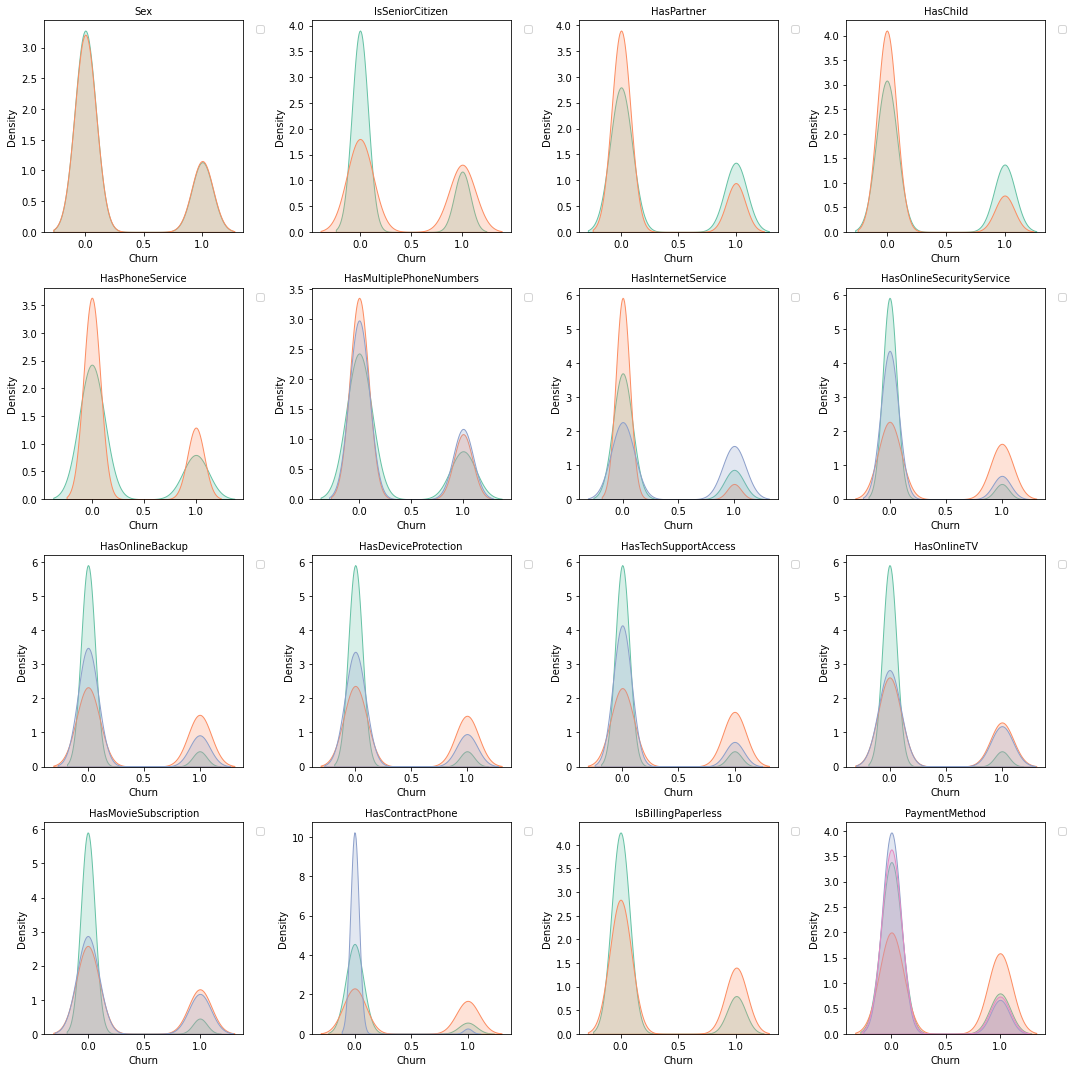

In [32]:
fig, axs = plt.subplots(4, len(cat_cols) // 4, figsize=(15,15))
axs = axs.flatten()

for cat_col, ax in zip(cat_cols, axs):
     display_group_density_plot(data, groupby = cat_col, on = target_col, \
                                           palette = sns.color_palette('Set2'), 
                                title=cat_col,
                           figsize = (10, 5), ax=ax)

plt.tight_layout()
plt.show()

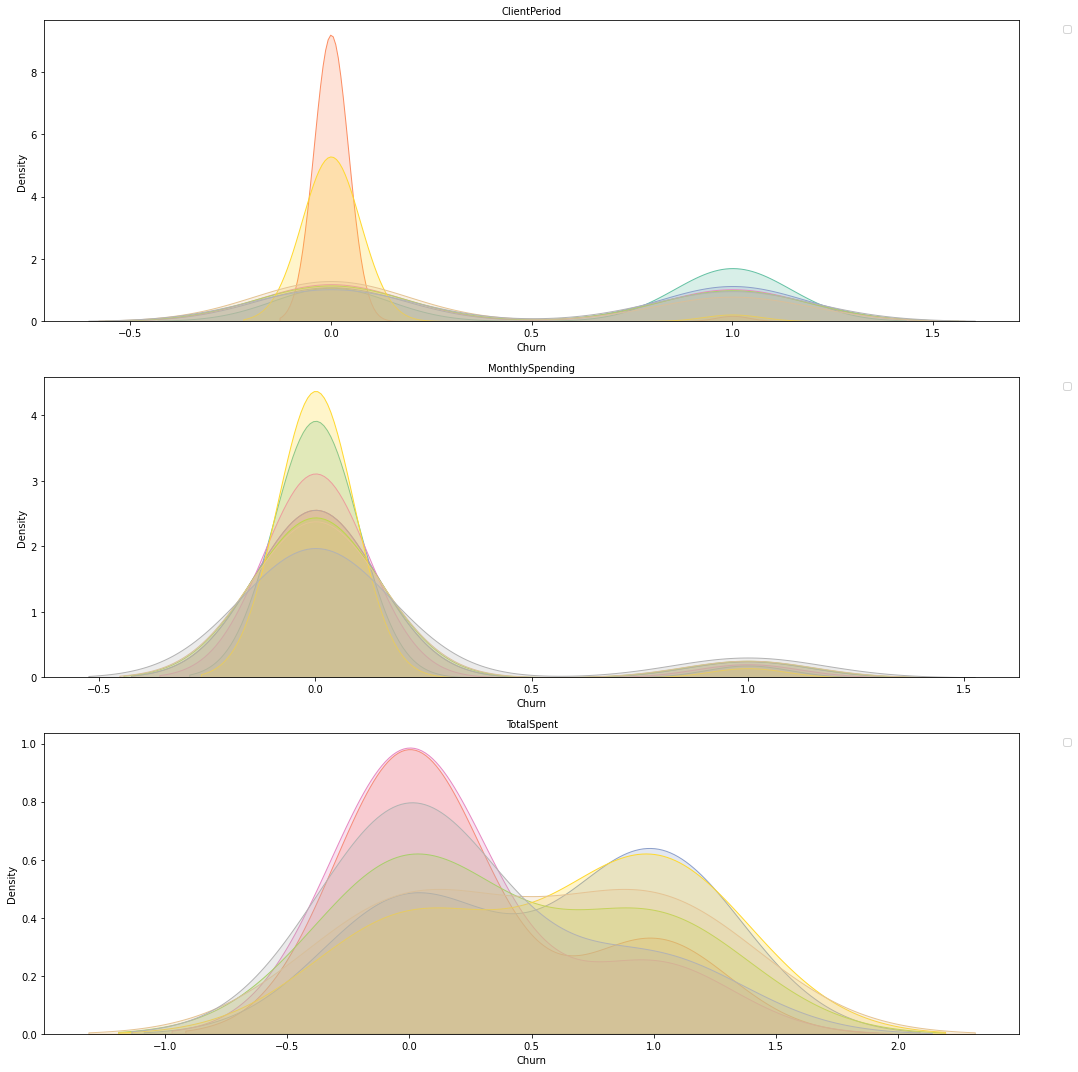

In [33]:
fig, axs = plt.subplots(3, len(num_cols) // 3, figsize=(15,15))
axs = axs.flatten()

for num_col, ax in zip(num_cols, axs):
     display_group_density_plot(data, groupby = num_col, on = target_col, \
                                           palette = sns.color_palette('Set2'), 
                                title=num_col,
                           figsize = (10, 5), ax=ax)

plt.tight_layout()
plt.show()

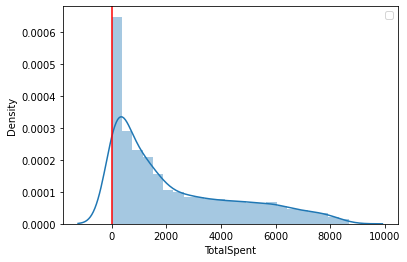

In [ ]:
sns.distplot(data["TotalSpent"])
plt.axvline(0, c="r", label="")
plt.legend()

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

числовые данные плюс минус в порядке, TotalSpent можно отскалировать, категориальные не смотрел

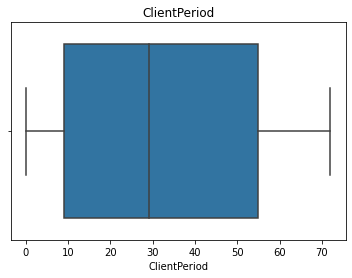

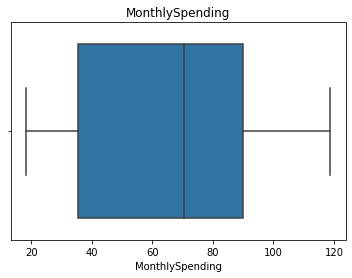

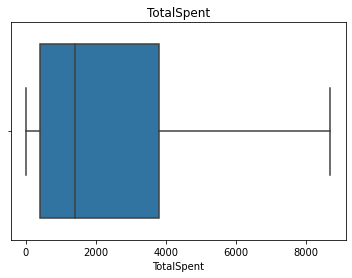

In [ ]:
for col in num_cols:
  sns.boxplot(data[col])
  plt.title(col)
  plt.show()

In [ ]:
describe_full(data, target_col)

,count,mean,std,min,25%,50%,75%,max,corr_with_target,dtypes,Missing count,Missing %,Cardinality,Skew,outliers,kurtosis
ClientPeriod,5282.0,32.397009,24.550326,0.00,9.0000,29.00,55.0000,72.00,-0.350640,int64,0,0.0,73,0.241959,0,-1.380820
MonthlySpending,5282.0,64.924754,30.176464,18.25,35.4625,70.40,90.0500,118.75,0.184769,float64,0,0.0,1468,-0.223028,0,-1.261744
TotalSpent,5282.0,2287.486161,2269.049195,0.00,395.7250,1405.65,3795.2125,8684.80,-0.200033,float64,0,0.0,4978,0.956448,0,-0.236097
IsSeniorCitizen,5282.0,0.159409,0.366092,0.00,0.0000,0.00,0.0000,1.00,0.156872,int64,0,0.0,2,1.861388,0,1.465321
Churn,5282.0,0.262022,0.439776,0.00,0.0000,0.00,1.0000,1.00,NaN,int64,0,0.0,2,1.082679,0,-0.828120


In [ ]:
data.corr()

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn
ClientPeriod,1.000000,0.249414,0.826658,0.011561,-0.350640
MonthlySpending,0.249414,1.000000,0.652014,0.215456,0.184769
TotalSpent,0.826658,0.652014,1.000000,0.094640,-0.200033
IsSeniorCitizen,0.011561,0.215456,0.094640,1.000000,0.156872
Churn,-0.350640,0.184769,-0.200033,0.156872,1.000000


ClientPeriod и TotalSpent сильно коррелируют, что логично, также MonthlySpending коррелирует с TotalSpent, можно попробовать в дальнейшем убирать сильно коррелирующие фичи

In [20]:
encoder = CatBoostEncoder(cols=cat_cols)

In [33]:
df = data.copy()
df[cat_cols] = encoder.fit_transform(df[cat_cols], df["Churn"])

In [42]:
def highlight_values(s, value=0.65):
    is_values = s.abs() >= value
    return ['background-color: green' if v else '' for v in is_values]

In [43]:
df.corr().style.apply(highlight_values)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
ClientPeriod,1.000000,0.248047,0.826167,0.005789,0.003085,-0.355040,-0.144168,-0.017819,0.147329,0.026306,-0.244875,-0.223536,-0.166233,-0.221041,0.004354,-0.007202,-0.667090,0.004994,-0.246911,-0.348881
MonthlySpending,0.248047,1.000000,0.651984,0.000075,0.191540,-0.089984,0.116283,-0.094524,0.125701,0.876259,0.430980,0.442481,0.520738,0.435939,0.689091,0.681627,0.068036,0.333824,0.207906,0.185915
TotalSpent,0.826167,0.651984,1.000000,-0.002801,0.078204,-0.298630,-0.051774,-0.051604,0.165796,0.411015,-0.014297,0.007900,0.094419,0.004677,0.314161,0.302059,-0.452058,0.149349,-0.110338,-0.198164
Sex,0.005789,0.000075,-0.002801,1.000000,0.202710,0.142028,0.210975,0.313264,0.219173,0.059620,0.058806,0.066204,0.098395,0.048237,0.107550,0.104215,0.059719,0.144492,0.071868,0.000381
IsSeniorCitizen,0.003085,0.191540,0.078204,0.202710,1.000000,0.065694,0.261866,0.132853,0.133212,0.263811,0.197413,0.151266,0.182516,0.217299,0.191493,0.191514,0.159129,0.187669,0.178745,0.146883
HasPartner,-0.355040,-0.089984,-0.298630,0.142028,0.065694,1.000000,0.456366,0.078755,-0.040868,0.020181,0.131997,0.112926,0.110594,0.111051,0.038235,0.039225,0.289699,0.044747,0.123613,0.135024
HasChild,-0.144168,0.116283,-0.051774,0.210975,0.261866,0.456366,1.000000,0.082132,0.056158,0.201574,0.213025,0.177007,0.184456,0.199152,0.172346,0.174329,0.245841,0.140035,0.169632,0.152223
HasPhoneService,-0.017819,-0.094524,-0.051604,0.313264,0.132853,0.078755,0.082132,1.000000,0.733399,0.031476,0.071994,0.103718,0.116635,0.069720,0.127456,0.135678,0.053823,0.055809,0.062133,0.003419
HasMultiplePhoneNumbers,0.147329,0.125701,0.165796,0.219173,0.133212,-0.040868,0.056158,0.733399,1.000000,0.153968,0.100772,0.102899,0.148059,0.118197,0.200577,0.192826,-0.018651,0.087026,0.066859,0.020679
HasInternetService,0.026306,0.876259,0.411015,0.059620,0.263811,0.020181,0.201574,0.031476,0.153968,1.000000,0.574698,0.545778,0.625380,0.597531,0.702807,0.702477,0.288200,0.366537,0.323051,0.309842


довольно много фич коррелирует между собой, 
1. TotalSpent и ClientPeriod, отмеченные ранее, 
2. набор категориальных фичей, связанных с интернет/кино сервисами (HasOnlineBackup, HasDeviceProtection, HasTechSupportAccess, HasOnlineTV, HasMovieSubscription), это можно также увидеть по heatmap. их либо надо как-то объединить в одно по смыслу, либо убрать лишнее, либо использовать recursive feature elimination. 
3. HasContractPhone и ClientPeriod
4. довольно неожиданно, MonthlySpending и HasInternetService, больше коррелируют чем, связанные по смыслу MonthlySpending и TotalSpent. возможно клиенты больше ориентированы на интернет, чем на что либо еще


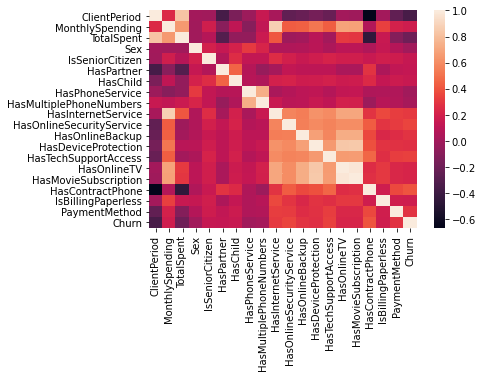

In [45]:
sns.heatmap(df.corr());

помимо TotalSpent vs ClientPeriod, прослеживается тенденция, чем период клиента и он больше платит, тем больше шанс его ухода. по логике вещей в подобных кейсах лучше делить клиентов по группам и исследовать каждую (а возможно и строить модель) отдельно, но из простоты, будем все же строить одну модель

можно еще проверить значимость категории по chi square test

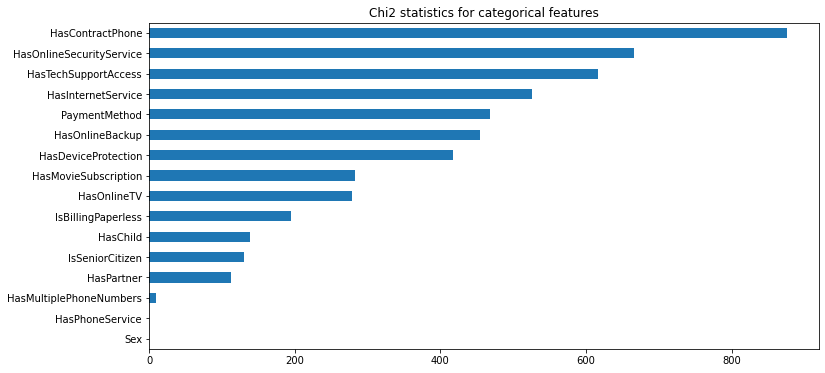

In [50]:
import scipy.stats as ss
stats = []
imp_stats = []
imp_cat_cols = []
for cat_col in cat_cols:
    contingency_table = pd.crosstab(data[cat_col], data['Churn'])
    chi2_stat, p_value = ss.chi2_contingency(observed=contingency_table)[:2]
    stats.append(chi2_stat)
    if p_value < 0.01:
        imp_stats.append(chi2_stat)
        imp_cat_cols.append(cat_col)
plt.figure(figsize=(12, 6))
series = pd.Series(stats, index=cat_cols).sort_values(ascending=True)
series.plot(kind='barh')
plt.title('Chi2 statistics for categorical features');

как видим Sex и HasPhoneService не значимы (могу сказать, забегая вперед это видно и по результатам модели, используя и убирая эти категории)

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

для линейной модели можно бинарные категории просто в int перевести

In [37]:
df = data.copy()

все же как было замечено выше, давайте выделим клиентов по группам в зависимости от ClientPeriod, поскольку мы заметили разницу в поведении

In [39]:
def map_client_period(ClientPeriod):
    if ClientPeriod < 13:
        return "0-12"
    elif ClientPeriod < 25:
        return "12-24"
    elif ClientPeriod < 49:
        return "24-48"
    else:
        return ">48"

In [40]:
df["ClientPeriodGroup"] = df["ClientPeriod"].apply(map_client_period)

была идея объединить сервисы в один, но простое sum , не дало прироста метрики, было проверено

In [ ]:
# df["HasServices"] = (df["HasOnlineBackup"].astype("category").cat.codes + df["HasDeviceProtection"].astype("category").cat.codes + df["HasTechSupportAccess"].astype("category").cat.codes + df["HasOnlineTV"].astype("category").cat.codes + df["HasMovieSubscription"].astype("category").cat.codes)

In [ ]:
# for col in ["HasPartner",	"HasChild", "HasPhoneService", "IsBillingPaperless"]:
#   df[col] = (df[col] == "Yes").astype("int")
# df["Sex"] = (df["Sex"] == "Male").astype("int")
# df = pd.get_dummies(df, drop_first=True)

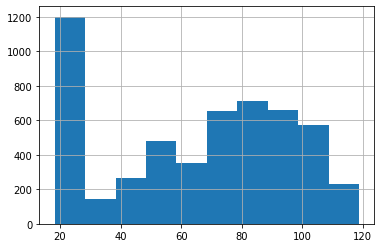

In [45]:
df["MonthlySpending"].hist()

In [46]:
df["MonthlySpendingGroup"] = (df["MonthlySpending"]<40).astype("int")

In [57]:
X, y = df[set(feature_cols) - set(["Sex", "HasPhoneService"])], df[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [49]:
feature_cols = [
#  'ClientPeriod',
#  'MonthlySpending',
'MonthlySpendingGroup',
 'TotalSpent',
#  'Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
#  'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod',
#  'HasServices',
 'ClientPeriodGroup']

In [50]:
cat_cols = [
            # 'Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
#  'HasPhoneService',
'MonthlySpendingGroup',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod',
#  'HasServices',
 'ClientPeriodGroup']

In [51]:
X, y = df[feature_cols], df[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [87]:
scaling_mapper = DataFrameMapper([
     (["TotalSpent"], StandardScaler())
 ])
ohe_mapper = DataFrameMapper([
     (cat_cols, OneHotEncoder())
 ])

pipe = Pipeline([
    ('encoder', make_union(scaling_mapper, ohe_mapper)),                 
    ('model', LogisticRegressionCV(class_weight=class_weights, cv=StratifiedKFold(n_splits=4), Cs=np.linspace(1, 10, 10), random_state=42, refit=True, scoring="roc_auc", solver='liblinear', max_iter=500))
])
pipe.fit(X_train, y_train);

In [88]:
y_pred = pipe.predict(X_val)
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_train_pred_proba = pipe.predict_proba(X_val)[:, 1]

print(f'ROC-AUC LR CV: {roc_auc_score(y_val, y_pred_proba)}')

ROC-AUC LR CV: 0.817726643229999


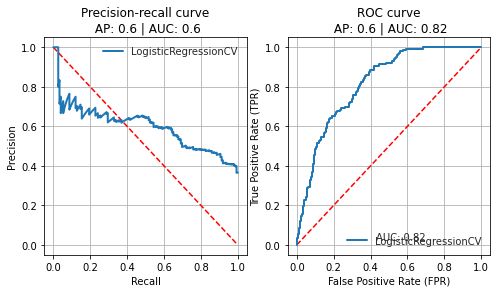

In [89]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
plot_pr(y_val, y_pred_proba, ax=ax[0],label="LogisticRegressionCV")
plot_roc(y_val, y_pred_proba, ax=ax[1],label="LogisticRegressionCV")

один из способов закодировать категории это использовать get_dummies, либо даже вручную бинарно закодировать бинарные фичи, но дайте воспользуемся CatBoostEncoder

In [62]:
encoder = CatBoostEncoder(cols=cat_cols)

scaling_mapper = DataFrameMapper([
     (["TotalSpent"], StandardScaler())
 ])

pipe = Pipeline([
    ("encoder", make_union(scaling_mapper, encoder)),
    ('model', LogisticRegressionCV(cv=StratifiedKFold(n_splits=4), Cs=np.linspace(1, 10, 10), random_state=42, refit=True, scoring="roc_auc", solver='liblinear', max_iter=500))
]).fit(X_train, y_train)

y_pred = pipe.predict(X_val)
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
y_train_pred_proba = pipe.predict_proba(X_val)[:, 1]

print(f'ROC-AUC LR CV: {roc_auc_score(y_val, y_pred_proba)}')

ROC-AUC LR CV: 0.7917865132630233


In [60]:
display_classification_report(y_val, y_pred)

,precision,recall,f1-score,support
0,0.780045,0.910053,0.840049,378.000000
1,0.604651,0.348993,0.442553,149.000000
accuracy,0.751423,0.751423,0.751423,0.751423
macro avg,0.692348,0.629523,0.641301,527.000000
weighted avg,0.730456,0.751423,0.727664,527.000000


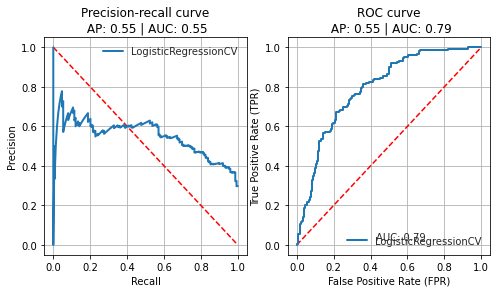

In [61]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
plot_pr(y_val, y_pred_proba, ax=ax[0],label="LogisticRegressionCV")
plot_roc(y_val, y_pred_proba, ax=ax[1],label="LogisticRegressionCV")

In [90]:
from sklearn.compose import *

preprocess = ColumnTransformer(remainder='passthrough',
                               transformers=[
                                            
                                             ('binary_data', OneHotEncoder(drop='first'), cat_cols),
                                            
                                             ('scale_data', StandardScaler(), ['TotalSpent'])
                                            ])


In [91]:
pip_log = Pipeline(steps=[
                          ('pre_processing', preprocess),
                          ('logistic_regression', LogisticRegression(class_weight=class_weights, max_iter=1000, 
                                                                     random_state=42))
                         ]
                  )

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s


Best score for pipeline: 0.845472674424742
Best pipeline: Pipeline(memory=None,
         steps=[('pre_processing',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('binary_data',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'MonthlyS

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.2s finished


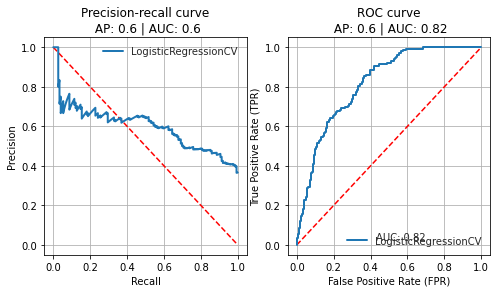

In [92]:
params = {'logistic_regression__C': np.linspace(0, 10, 10),
          'logistic_regression__class_weight': ['none', 'balanced'],
          'logistic_regression__solver': ['newton-cg', 'lbfgs', 'sag']}

grid = GridSearchCV(pip_log, params, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1).fit(X_train, y_train)

print(f'Best score for pipeline: {grid.best_score_}')
print(f'Best pipeline: {grid.best_estimator_}')


y_pred_proba = grid.predict_proba(X_val)[:, 1]

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax = ax.flatten()
plot_pr(y_val, y_pred_proba, ax=ax[0],label="LogisticRegressionCV")
plot_roc(y_val, y_pred_proba, ax=ax[1],label="LogisticRegressionCV")

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

были попробованы CV с one hot encoding и catboostencoder из библиотеки, лучшее качество было в первом случае 0.82

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [76]:
X, y = df[feature_cols], df[target_col]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_state)
train_ds = Pool(data=X_train, label=y_train, cat_features=cat_cols, feature_names=feature_cols)
test_ds = Pool(data=X_val, label=y_val, cat_features=cat_cols, feature_names=feature_cols)
full_ds = Pool(data=X, label=y, cat_features=cat_cols, feature_names=feature_cols)

In [77]:
scale_pos_weight=(y_train==0).sum()/(y_train==1).sum()

In [78]:
cb = CatBoostClassifier(verbose=0, scale_pos_weight=scale_pos_weight,task_type="GPU", 
                        devices='0:1', random_seed=random_state).fit(train_ds)


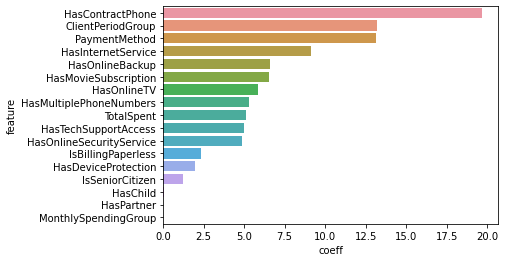

In [79]:
df_feature_importances = pd.DataFrame(((zip(cb.feature_names_, cb.get_feature_importance())))).rename(columns={0:"feature",1:"coeff"}).sort_values(by="coeff", ascending = False )
sns.barplot(data=df_feature_importances, x=df_feature_importances["coeff"], y=df_feature_importances["feature"])

In [80]:
y_pred = cb.predict(test_ds)
print(cb.score(train_ds))

0.7633410672853829


0.7191650853889943
[[268 110]
 [ 38 111]]


,precision,recall,f1-score,support
0,0.875817,0.708995,0.783626,378.000000
1,0.502262,0.744966,0.600000,149.000000
accuracy,0.719165,0.719165,0.719165,0.719165
macro avg,0.689040,0.726981,0.691813,527.000000
weighted avg,0.770201,0.719165,0.731709,527.000000


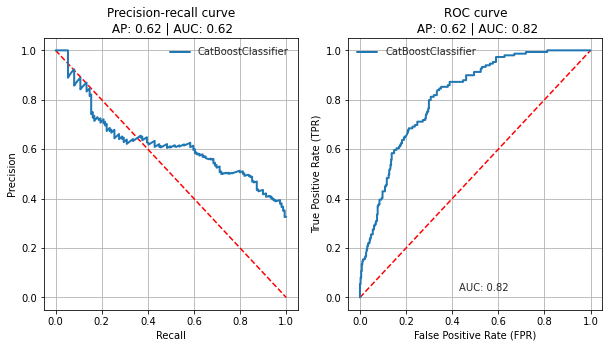

In [192]:
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))
display_classification_report(y_val, y_pred)

y_pred_proba = cb.predict_proba(X_val)[:, 1]
y_train_pred_proba = cb.predict_proba(X_val)[:, 1]


_, axs = plt.subplots(1, 2,figsize=(10,5))
axs = axs.ravel()
plot_pr(y_val, y_pred_proba, ax=axs[0], label="CatBoostClassifier")
plot_roc(y_val, y_pred_proba, ax=axs[1], label="CatBoostClassifier")

In [97]:
param_grid = {
        'learning_rate': [0.03, 0.003],
        'depth': [16],
        'l2_leaf_reg': [3, 7],
        'iterations':[1000],
        'thread_count':[12],
        'border_count':[128]
}



model = CatBoostClassifier(eval_metric='AUC:hints=skip_train~false', task_type="GPU", devices='0:1', random_seed=random_state, 
                                       thread_count=-1)
grid_search_result = model.grid_search(param_grid, 
                                       full_ds,
                                       verbose=0,
                                       partition_random_seed=random_state,
                                       search_by_train_test_split=True,
                                       train_size=0.9,
                                       plot=False)
# eval_set = [(X_val, y_val)], use_best_model=True

0:	learn: 0.8197935	test: 0.7898806	best: 0.7898806 (0)	total: 43.1ms	remaining: 43.1s
1:	learn: 0.8297098	test: 0.7949552	best: 0.7949552 (1)	total: 86ms	remaining: 42.9s
2:	learn: 0.8312275	test: 0.7993931	best: 0.7993931 (2)	total: 127ms	remaining: 42.1s
3:	learn: 0.8337181	test: 0.8039801	best: 0.8039801 (3)	total: 167ms	remaining: 41.5s
4:	learn: 0.8344837	test: 0.8056020	best: 0.8056020 (4)	total: 209ms	remaining: 41.6s
5:	learn: 0.8360624	test: 0.8066866	best: 0.8066866 (5)	total: 251ms	remaining: 41.6s
6:	learn: 0.8396067	test: 0.8092736	best: 0.8092736 (6)	total: 292ms	remaining: 41.4s
7:	learn: 0.8409393	test: 0.8097712	best: 0.8097712 (7)	total: 337ms	remaining: 41.7s
8:	learn: 0.8408855	test: 0.8120796	best: 0.8120796 (8)	total: 376ms	remaining: 41.4s
9:	learn: 0.8404812	test: 0.8131144	best: 0.8131144 (9)	total: 417ms	remaining: 41.3s
10:	learn: 0.8412333	test: 0.8131244	best: 0.8131244 (10)	total: 458ms	remaining: 41.1s
11:	learn: 0.8418780	test: 0.8136020	best: 0.8136020

In [98]:
cv_data = pd.DataFrame(grid_search_result["cv_results"])
best_value = cv_data['test-AUC-mean'].max()
best_iter = cv_data['test-AUC-mean'].values.argmax()

print('Best validation test-AUC-mean : {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-AUC-std'][best_iter],
    best_iter)
)

Best validation test-AUC-mean : 0.8448±0.0089 on step 326


In [100]:
model = CatBoostClassifier(task_type="GPU", devices='0:1', random_seed=random_state, **grid_search_result["params"])
model.fit(train_ds, verbose = 0, eval_set = [(X_val, y_val)], use_best_model=True)
y_pred = model.predict(test_ds)
print("accuracy_score", accuracy_score(y_val, y_pred))
for i in [10, 15, 20]:
  print("roc_auc_score", roc_auc_score(y_val, model.predict_proba(test_ds, ntree_start=0, ntree_end=i)[:,1]))
print("f1_score", f1_score(y_val, y_pred))

accuracy_score 0.7741935483870968
roc_auc_score 0.7986222080181812
roc_auc_score 0.8004864884059515
roc_auc_score 0.8025283193068428
f1_score 0.5405405405405406


In [101]:
print(roc_auc_score(y_val, model.predict_proba(test_ds)[:,1]))

0.8188629665139732


In [147]:
class paramsearch:
    def __init__(self,pdict):    
        self.pdict = {}
        # if something is not passed in as a sequence, make it a sequence with 1 element
        #   don't treat strings as sequences
        for a,b in pdict.items():
            if isinstance(b, collections.Sequence) and not isinstance(b, str): self.pdict[a] = b
            else: self.pdict[a] = [b]
        # our results are a sorted list, so the best score is always the final element
        self.results = SortedList()       
                    
    def grid_search(self,keys=None):
        # do grid search on only the keys listed. If none provided, do all
        if keys==None: keylist = self.pdict.keys()
        else: keylist = keys
 
        listoflists = [] # this will be list of lists of key,value pairs
        for key in keylist: listoflists.append([(key,i) for i in self.pdict[key]])
        for p in product(*listoflists):
            # do any changes to the current best parameter set
            if len(self.results)>0: template = self.results[-1][1]
            else: template = {a:b[0] for a,b in self.pdict.items()}
            # if our updates are the same as current best, don't bother
            if self.equaldict(dict(p),template): continue
            # take the current best and update just the ones to change
            yield self.overwritedict(dict(p),template)
                              
    def equaldict(self,a,b):
        for key in a.keys(): 
            if a[key] != b[key]: return False
        return True            
                              
    def overwritedict(self,new,old):
        old = copy.deepcopy(old)
        for key in new.keys(): old[key] = new[key]
        return old            
    
    # save a (score,params) pair to results. Since 'results' is a sorted list,
    #   the best score is always the final element. A small amount of noise is added
    #   because sorted lists don't like it when two scores are exactly the same    
    def register_result(self,result,params):
        self.results.add((result+np.random.randn()*1e-10,params))    
        
    def bestscore(self):
        return self.results[-1][0]
        
    def bestparam(self):
        return self.results[-1][1]

In [151]:
def run_grid_search(train_set, test_set, y_train, y_test):


    # X, y = data[feature_cols], data[target_col]
    # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=random_state)
    # full_ds = Pool(data=X, label=y, cat_features=cat_cols, feature_names=feature_cols)

    colnames = feature_cols
    category_cols = cat_cols
    cat_dims = [train_set.columns.get_loc(i) for i in category_cols[:-1]] 
    # for header in category_cols:
    #     train_set[header] = train_set[header].astype('category').cat.codes
    #     test_set[header] = test_set[header].astype('category').cat.codes

    # split labels out of data sets    
    train_label = y_train.values
    test_label = y_test.values

    # params = {'depth':[3,1,2,6,4,5,7,8,9,10],
    #           'iterations':[250,100,500,1000],
    #           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
    #           'l2_leaf_reg':[3,1,5,10,100],
    #           'border_count':[32,5,10,20,50,100,200],
    #           'thread_count':4}

    params = {'depth':[4],
              'iterations':[500,1000, 1500],
              'learning_rate':[0.03,0.003, 0.001], 
              'l2_leaf_reg':[3],
              'border_count':[12,13,14],
              'thread_count':[4],
              'bagging_temperature':[0,1,2]}

    #           {'border_count': 12,
    #  'depth': 4,
    #  'iterations': 500,
    #  'l2_leaf_reg': 3,
    #  'learning_rate': 0.03,
    #  'thread_count': 4}

    #  {'depth': 4, 'iterations': 500, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 10, 'thread_count': 4}
    # this function does 3-fold crossvalidation with catboostclassifier          
    def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
        kf = KFold(n_splits=n_splits,shuffle=True) 
        res = []
        for train_index, test_index in kf.split(train_set):
            train = train_set.iloc[train_index,:]
            test = train_set.iloc[test_index,:]
            
            labels = train_label[train_index]
            test_labels = train_label[test_index]

            train_ds = Pool(data=train, label=labels, cat_features=cat_cols, feature_names=feature_cols)
            test_ds = Pool(data=test, label=test_labels, cat_features=cat_cols, feature_names=feature_cols)

            scale_pos_weight=(labels==0).sum()/(labels==1).sum()
            clf = CatBoostClassifier(**params, verbose=0, scale_pos_weight=scale_pos_weight)
            clf.fit(train_ds)
            res.append(np.mean(roc_auc_score(test_labels, clf.predict_proba(test_ds)[:,1])))
            # res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
        return np.mean(res)
      
    # this function runs grid search on several parameters
    def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
        ps = paramsearch(params)
        # search 'border_count', 'l2_leaf_reg' etc. individually 
        #   but 'iterations','learning_rate' together
        max_metric = 0
        best_param = {}
        for prms in chain(ps.grid_search(['border_count']),
                          ps.grid_search(['l2_leaf_reg']),
                          ps.grid_search(['iterations','learning_rate']),
                          ps.grid_search(['depth'])):
            res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
            # save the crossvalidation result so that future iterations can reuse the best parameters
            ps.register_result(res,prms)
            if max_metric<res: 
              max_metric = res
              best_param = prms
            print(res,prms,'best:',ps.bestscore(),ps.bestparam())
        # return ps.bestparam()
        return best_param

    return catboost_param_tune(params,train_set,train_label,cat_dims)

In [142]:
train_ds = Pool(data=X_train, label=y_train, cat_features=cat_cols, feature_names=feature_cols)
test_ds = Pool(data=X_val, label=y_val, cat_features=cat_cols, feature_names=feature_cols)
full_ds = Pool(data=X, label=y, cat_features=cat_cols, feature_names=feature_cols)
train_set = X_train
test_set = X_val

In [ ]:
bestparams = run_grid_search(train_set, test_set, y_train, y_val)

In [143]:
bestparams = {'depth': 4, 'iterations': 1000, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 14, 'thread_count': 4}
clf = CatBoostClassifier(**bestparams, verbose=0)
clf.fit(train_set, np.ravel(y_train), cat_features=cat_cols)
score = roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])
print(f"{score:.2f}")

0.85


можно было еще попробовать различные способы выбора фич, на основе корреляции, пример

In [ ]:
# !pip install git+https://github.com/sv1990/CorrelationThreshold/
# from correlation_threshold import CorrelationThreshold

# X = pd.DataFrame(...)

# ct = CorrelationThreshold(r_threshold=0.5, p_threshold=0.05)

# X2 = ct.fit_transform(X)

или используя стандартный sklearn, rfe и т.п.

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

# Предсказания

In [121]:
best_model = clf

In [122]:
X_test = pd.read_csv('test.csv')

In [123]:
def convert_data(data):
  data["TotalSpent"] = data["TotalSpent"].str.strip()
  data.loc[data["TotalSpent"] == "", "TotalSpent"] = "0.0" 
  data["TotalSpent"] = pd.to_numeric(data["TotalSpent"], errors="raise")
  return data

In [124]:
X_test = convert_data(X_test)

In [125]:
# X_test["MonthlySpendingGroup"] = (X_test["MonthlySpending"]<40).astype("int")
X_test["ClientPeriodGroup"] = X_test["ClientPeriod"].apply(map_client_period)

In [126]:
test_ds = Pool(data=X_test[feature_cols].values, cat_features=cat_cols, feature_names=feature_cols)

In [135]:
submission = pd.read_csv('submission.csv')

result = []
for i in np.random.randint(1,1000,size=10):
  bestparams = {'depth': 4, 'iterations': 500, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'border_count': 14, 'thread_count': 4}
  clf = CatBoostClassifier(**bestparams, verbose=0)
  clf.fit(full_ds)
  result.append(clf.predict_proba(test_ds)[:,1])

In [138]:
submission['Churn'] = np.array(result).mean(axis=0)
submission.to_csv('./my_submission.csv', index=False)

In [ ]:
# submission = pd.read_csv('submission.csv')

# submission['Churn'] = my_pipeline.predict_proba(X_test[feature_cols])[:,1] # best_model.predict_proba(X_test) / best_model.predict(X_test)
# submission.to_csv('./my_submission.csv', index=False)

In [ ]:
!kaggle competitions submit advanced-dls-spring-2021 -f my_submission.csv -m ""

In [ ]:
##colab
try:
  from google.colab import files
  files.download('my_submission.csv')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

результат 0.85169 ,что достаточно (поскольку больше 84;))

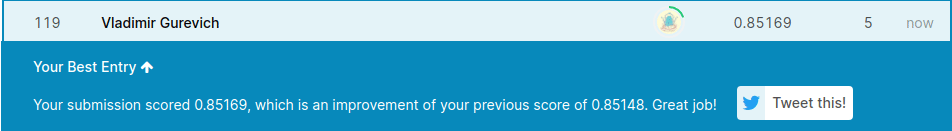

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.